Question 1 

Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

Taken label using 

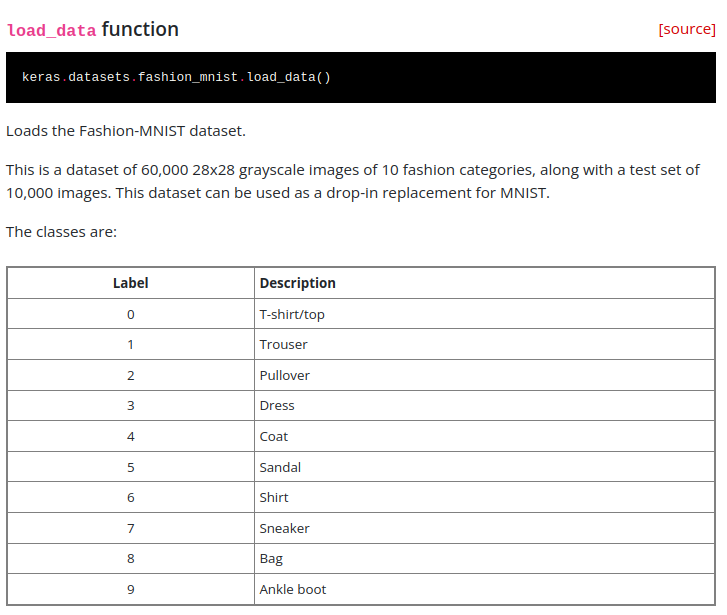


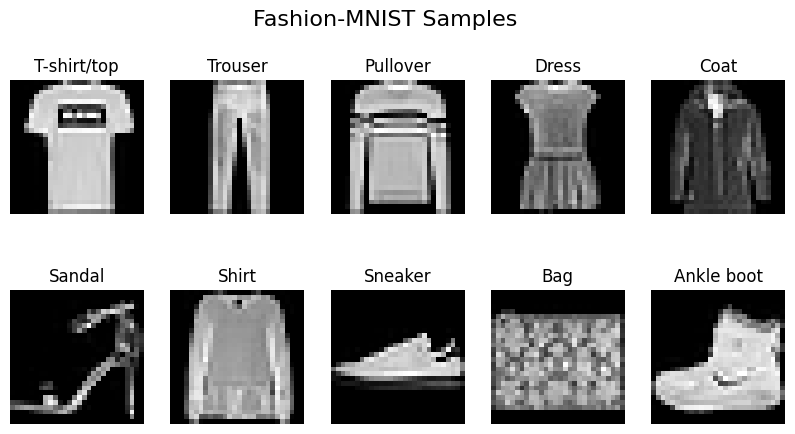

In [23]:

import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.datasets import fashion_mnist


(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


# identified classnames in keras website 

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


sample_images = []

for i in range(10):  # 10 classes in Fashion MNIST
    index = np.where(train_labels == i)[0][0]  # Find the first occurrence of each class
    sample_images.append(train_images[index])
    # sample_labels.append(class_names[i])
    
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Samples", fontsize=16)

for ax, img, label in zip(axes.flat, sample_images, class_names):
    ax.imshow(img, cmap='gray')  # Display grayscale image
    ax.set_title(label)  # Set class name as title
    ax.axis("off")  # Hide axes

# Printing via wandb.ai
# wandb.login()
    
# wandb.init(project="fashion_mnist_sweep",entity="ch24s016-iitm",name='sample images category')

# wandb.log({"Image from each class": [wandb.Image(image, caption=caption) for image, caption in zip(sample_images, class_names)]})



Question 2 

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

In [24]:
# DATA PREPROCESSING

# Load Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print(train_images.shape)
print(test_images.shape)

# Normalize pixel values (0-255) -> (0-1)

train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0


train_images_splitted = train_images[:54000]


# One-hot encode labels
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels_splitted = one_hot_encode(train_labels[:54000])
test_labels = one_hot_encode(test_labels)

val_images = train_images[54000:] # 10% from training dataset is 6000 data point taken as validation dataset from training
val_labels = one_hot_encode(train_labels[54000:]) # 10% from training dataset labels


# all shapes of train , validation and testing datasets 
print('the shape of training images and its training labels',train_images_splitted.shape,len(train_labels_splitted))
print('the shape of validation images and its validation labels',val_images.shape,len(val_labels))
print('the shape of testing images and its testing labels',test_images.shape,len(test_labels))



(60000, 28, 28)
(10000, 28, 28)
the shape of training images and its training labels (54000, 784) 54000
the shape of validation images and its validation labels (6000, 784) 6000
the shape of testing images and its testing labels (10000, 784) 10000


In [25]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_neurons, hidden_layers, output_neurons):
        
        self.layers = [input_neurons] + hidden_layers + [output_neurons]
        self.weights = {}
        self.biases = {}

        # Initialize weights and biases
        for i in range(len(self.layers) - 1):
            self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            self.biases[i] = np.zeros((1, self.layers[i+1]))


    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Avoid overflow
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        self.activations = {}
        self.z_values = {}

        # Input Layer
        self.activations[0] = X

        # Hidden Layers
        for i in range(len(self.layers) - 2):
            self.z_values[i] = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            self.activations[i+1] = self.relu(self.z_values[i])

        # Output Layer (Softmax)
        last_layer = len(self.layers) - 2
        self.z_values[last_layer] = np.dot(self.activations[last_layer], self.weights[last_layer]) + self.biases[last_layer]
        self.activations[last_layer+1] = self.softmax(self.z_values[last_layer])

        return self.activations[last_layer+1]

    def train(self, X):
        activations = self.forward(X)
        print('output of feed forward after passing whole network of one data point is ',activations[0])

# Example Usage:

hidden_layers = [128, 64]

# Initialize model
model = NeuralNetwork(input_neurons=784, hidden_layers=hidden_layers, output_neurons=10)

# print('the size of training dataset is',train_images.shape)
# print('the size of training dataset is',test_images.shape)

# Train (Assume train_images is your training data and train_labels is one-hot encoded labels)
model.train(train_images_splitted)


output of feed forward after passing whole network of one data point is  [0.10006076 0.10010025 0.09996668 0.1000358  0.09994132 0.09990593
 0.09999605 0.10002775 0.0999359  0.10002954]


Question 3

Implement the backpropagation algorithm with support for the following optimisation functions

sgd
momentum based gradient descent
nesterov accelerated gradient descent
rmsprop
adam
nadam
(12 marks for the backpropagation framework and 2 marks for each of the optimisation algorithms above)

We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

Epoch 1/10 - Train Loss: 0.6233, Train Acc: 0.7687, Val Loss: 0.4059, Val Acc: 0.8543
Epoch 2/10 - Train Loss: 0.3833, Train Acc: 0.8627, Val Loss: 0.3842, Val Acc: 0.8542
Epoch 3/10 - Train Loss: 0.3456, Train Acc: 0.8742, Val Loss: 0.3564, Val Acc: 0.8665
Epoch 4/10 - Train Loss: 0.3197, Train Acc: 0.8831, Val Loss: 0.3530, Val Acc: 0.8687
Epoch 5/10 - Train Loss: 0.3029, Train Acc: 0.8895, Val Loss: 0.3518, Val Acc: 0.8722
Epoch 6/10 - Train Loss: 0.2892, Train Acc: 0.8950, Val Loss: 0.3433, Val Acc: 0.8768
Epoch 7/10 - Train Loss: 0.2784, Train Acc: 0.8981, Val Loss: 0.3236, Val Acc: 0.8780
Epoch 8/10 - Train Loss: 0.2670, Train Acc: 0.9019, Val Loss: 0.3131, Val Acc: 0.8837
Epoch 9/10 - Train Loss: 0.2581, Train Acc: 0.9047, Val Loss: 0.3333, Val Acc: 0.8818
Epoch 10/10 - Train Loss: 0.2481, Train Acc: 0.9085, Val Loss: 0.3198, Val Acc: 0.8848


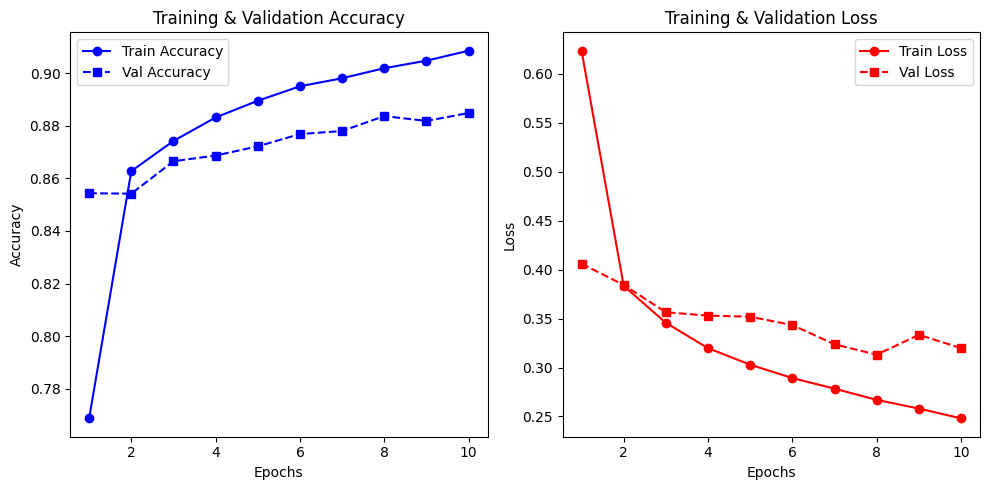

(np.float64(0.908537037037037),
 np.float64(0.8848333333333334),
 np.float64(0.24811153452389093),
 np.float64(0.3198046010401666))

In [34]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_neurons, hidden_layers, output_neurons, init_wb_method, optimizer, activation, learning_rate, beta1, beta2, epsilon=1e-8):
        self.layers = [input_neurons] + hidden_layers + [output_neurons]
        self.weights = {}
        self.biases = {}
        self.beta1 = beta1
        self.beta2 = beta2
        self.init_wb_method = init_wb_method
        self.epsilon = epsilon
        self.activation = activation

        if init_wb_method == 'random':
            for i in range(len(self.layers) - 1):
                self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
                self.biases[i] = np.zeros((1, self.layers[i+1]))

        elif init_wb_method == 'xavier':
            for i in range(len(self.layers) - 1):
                r = np.sqrt(6.0 / (self.layers[i] + self.layers[i+1]))
                self.weights[i] = np.random.uniform(-r, r, (self.layers[i], self.layers[i+1]))
                self.biases[i] = np.zeros((1, self.layers[i+1]))

        # Initialize optimizer parameters
        self.optimizer = optimizer
        self.learning_rate = learning_rate

        num_layers = len(self.layers) - 1  # Number of weight layers

        # For Adam, Nadam, and RMSprop
        self.m_w = {i: np.zeros_like(self.weights[i]) for i in range(num_layers)}
        self.v_w = {i: np.zeros_like(self.weights[i]) for i in range(num_layers)}
        self.m_b = {i: np.zeros_like(self.biases[i]) for i in range(num_layers)}
        self.v_b = {i: np.zeros_like(self.biases[i]) for i in range(num_layers)}
        
        # For Adam/Nadam timestep tracking
        self.t = 0

        # For Momentum and Nesterov
        self.velocity_w = {i: np.zeros_like(self.weights[i]) for i in range(num_layers)}
        self.velocity_b = {i: np.zeros_like(self.biases[i]) for i in range(num_layers)}


    # LIST OF ACTIVATION FUNCTIONS 

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Avoid overflow
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def softmax_derivative(self, output, y):
        return output - y
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        sig = self.sigmoid(x)
        return sig * (1 - sig)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def forward(self, X):
        self.activations = {}
        self.z_values = {}

        # Input Layer
        self.activations[0] = X

        # Hidden Layers
        for i in range(len(self.layers) - 2):
            self.z_values[i] = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            if self.activation == 'relu':
                self.activations[i+1] = self.relu(self.z_values[i])
            elif self.activation == 'sigmoid':
                self.activations[i+1] = self.sigmoid(self.z_values[i])
            elif self.activation == 'tanh':
                self.activations[i+1] = self.tanh(self.z_values[i])

        # Output Layer (Softmax)
        last_layer = len(self.layers) - 2
        self.z_values[last_layer] = np.dot(self.activations[last_layer], self.weights[last_layer]) + self.biases[last_layer]
        self.activations[last_layer+1] = self.softmax(self.z_values[last_layer])

        return self.activations[last_layer+1]
    
    def backward(self, X, y):
        m = X.shape[0]

        # Compute gradient for the output layer
        output = self.activations[len(self.layers) - 1]
        delta = self.softmax_derivative(output, y) / m

        # Backpropagate through the layers
        gradients_w = {}
        gradients_b = {}

        for i in reversed(range(len(self.layers) - 1)):
            gradients_w[i] = np.dot(self.activations[i].T, delta)
            gradients_b[i] = np.sum(delta, axis=0, keepdims=True)

            if i != 0:
                if self.activation == 'relu':
                    delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(self.z_values[i - 1])
                elif self.activation == 'sigmoid':
                    delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(self.z_values[i - 1])
                elif self.activation == 'tanh':
                    delta = np.dot(delta, self.weights[i].T) * self.tanh_derivative(self.z_values[i - 1])

        return gradients_w, gradients_b
    
    def optimization_functions(self, gradients_w, gradients_b):
        num_layers = len(self.layers) - 1

        if self.optimizer == 'sgd':
            for i in range(num_layers):
                self.weights[i] -= self.learning_rate * gradients_w[i]
                self.biases[i] -= self.learning_rate * gradients_b[i]

        elif self.optimizer == 'momentum':
            beta = 0.9
            for i in range(num_layers):
                self.velocity_w[i] = beta * self.velocity_w[i] + (1 - beta) * gradients_w[i]
                self.velocity_b[i] = beta * self.velocity_b[i] + (1 - beta) * gradients_b[i]
                self.weights[i] -= self.learning_rate * self.velocity_w[i]
                self.biases[i] -= self.learning_rate * self.velocity_b[i]

        elif self.optimizer == 'nesterov':
            beta = 0.9
            for i in range(num_layers):
                prev_velocity_w = self.velocity_w[i]
                prev_velocity_b = self.velocity_b[i]
                self.velocity_w[i] = beta * prev_velocity_w + (1 - beta) * gradients_w[i]
                self.velocity_b[i] = beta * prev_velocity_b + (1 - beta) * gradients_b[i]
                self.weights[i] -= self.learning_rate * (gradients_w[i] + beta * prev_velocity_w)
                self.biases[i] -= self.learning_rate * (gradients_b[i] + beta * prev_velocity_b)

        elif self.optimizer == 'rmsprop':
            decay_rate = 0.9
            epsilon = 1e-8
            for i in range(num_layers):
                self.m_w[i] = decay_rate * self.m_w[i] + (1 - decay_rate) * gradients_w[i]**2
                self.m_b[i] = decay_rate * self.m_b[i] + (1 - decay_rate) * gradients_b[i]**2
                self.weights[i] -= self.learning_rate * gradients_w[i] / (np.sqrt(self.m_w[i]) + epsilon)
                self.biases[i] -= self.learning_rate * gradients_b[i] / (np.sqrt(self.m_b[i]) + epsilon)

        elif self.optimizer == 'adam':
            self.t += 1
            for i in range(num_layers):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * gradients_w[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * gradients_w[i]**2
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * gradients_b[i]
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * gradients_b[i]**2

                m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2**self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2**self.t)

                self.weights[i] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == 'nadam':
            self.t += 1
            for i in range(num_layers):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * gradients_w[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * gradients_w[i]**2
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * gradients_b[i]
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * gradients_b[i]**2

                m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2**self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2**self.t)

                self.weights[i] -= self.learning_rate * (self.beta1 * m_w_hat + (1 - self.beta1) * gradients_w[i]) / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i] -= self.learning_rate * (self.beta1 * m_b_hat + (1 - self.beta1) * gradients_b[i]) / (np.sqrt(v_b_hat) + self.epsilon)
                    
            
    def train(self, X, y, epochs, batch_size, X_val, y_val, wb_log=True,plots=False):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            # Shuffle the data
            indices = np.random.permutation(len(X))
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            total_loss = 0
            correct_preds_train = 0

            for i in range(0, len(X), batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Forward pass
                predictions = self.forward(X_batch)

                # Compute loss (Cross-entropy loss)
                loss = -np.sum(y_batch * np.log(predictions + 1e-8)) / len(y_batch)  # Avoid log(0)
                total_loss += loss

                # Compute accuracy for training batch
                y_pred_labels = np.argmax(predictions, axis=1)
                y_true_labels = np.argmax(y_batch, axis=1)
                correct_preds_train += np.sum(y_pred_labels == y_true_labels)

                # Backward pass
                gradients_w, gradients_b = self.backward(X_batch, y_batch)

                # Update weights
                self.optimization_functions(gradients_w, gradients_b)

            # Compute training loss and accuracy
            avg_train_loss = total_loss / (len(X) / batch_size)
            train_losses.append(avg_train_loss)
            train_acc = correct_preds_train / len(X)
            train_accuracies.append(train_acc)

            # Compute validation loss and accuracy
            if X_val is not None and y_val is not None:
                val_predictions = self.forward(X_val)
                val_loss = -np.sum(y_val * np.log(val_predictions + 1e-8)) / len(y_val)
                val_losses.append(val_loss)

                # Compute validation accuracy
                val_pred_labels = np.argmax(val_predictions, axis=1)
                val_true_labels = np.argmax(y_val, axis=1)
                val_acc = np.sum(val_pred_labels == val_true_labels) / len(y_val)
                val_accuracies.append(val_acc)


                if wb_log:
                     wandb.log({'train_acc': train_acc, 'val_acc': val_acc, 'train_loss': avg_train_loss, 'val_loss': val_loss})

                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            else:
                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")


        epochs_range = np.arange(1, epochs + 1)

        if(plots):
            plt.figure(figsize=(10, 5))

            # Plot accuracy
            plt.subplot(1, 2, 1)
            plt.plot(epochs_range, train_accuracies, "bo-", label="Train Accuracy")
            plt.plot(epochs_range, val_accuracies, "bs--", label="Val Accuracy")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.title("Training & Validation Accuracy")
            plt.legend()

            # Plot loss
            plt.subplot(1, 2, 2)
            plt.plot(epochs_range, train_losses, "ro-", label="Train Loss")
            plt.plot(epochs_range, val_losses, "rs--", label="Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.title("Training & Validation Loss")
            plt.legend()

            plt.tight_layout()
            plt.show()

        

        return train_acc, val_acc, avg_train_loss ,val_loss


            
    def predict(self, X):
        return self.forward(X)

# Example Usage:

hidden_layers = [128, 64]
    
# Initialize model
model = NeuralNetwork(input_neurons=784, hidden_layers=hidden_layers, output_neurons=10,init_wb_method='random',activation='tanh',learning_rate=0.001,optimizer='nadam',beta1=0.9,beta2=0.99)

# Train (Assume train_images is your training data and train_labels is one-hot encoded labels)
model.train(train_images_splitted,train_labels_splitted,epochs=10,batch_size=32,X_val=val_images,y_val=val_labels,plots=True,wb_log=False)

Question 4

Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()). Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

number of epochs: 5, 10
number of hidden layers: 3, 4, 5
size of every hidden layer: 32, 64, 128
weight decay (L2 regularisation): 0, 0.0005, 0.5
learning rate: 1e-3, 1 e-4
optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
batch size: 16, 32, 64
weight initialisation: random, Xavier
activation functions: sigmoid, tanh, ReLU
wandb will automatically generate the following plots. Paste these plots below using the "Add Panel to Report" feature. Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU) instead of using the default names (whole-sweep, kind-sweep) given by wandb.

In [ ]:
import wandb

sweep_config = {
    "method": "bayes",  # Use Bayesian optimization for efficient search
    "metric": {"name": "val_loss", "goal": "minimize"},  # Minimize validation loss
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}

def train():
   run = wandb.init()  # Initialize W&B inside function
   config = wandb.config

   wandb.run.name = f"{config.weight_init}_{config.optimizer}_{config.activation}_bs_{config.batch_size}_layers_{config.hidden_layers}_neurons_{config.hidden_size}"

   # Initialize the model
   model = NeuralNetwork(
       input_neurons=784,
       hidden_layers=[config.hidden_size] * config.hidden_layers,
       output_neurons=10,
       optimizer=config.optimizer,
       learning_rate=config.learning_rate,
       init_wb_method=config.weight_init,
       activation=config.activation,
       beta1=0.9,
       beta2=0.999
   )

   # Train & Evaluate
   train_acc, val_acc, train_loss, val_loss = model.train(train_images_splitted, train_labels_splitted, config.epochs, config.batch_size, val_images, val_labels,plots=False,wb_log=True)

   # Log metrics
   


# Initialize and run the sweep
sweep_id = wandb.sweep(sweep_config, project="fashion_mnist_sweep")
wandb.agent(sweep_id, function=train, count=30)  # Run 30 trials

Create sweep with ID: rf1iknud
Sweep URL: https://wandb.ai/ch24s016-iitm/fashion_mnist_sweep/sweeps/rf1iknud


wandb: Agent Starting Run: j26381js with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Loss: 0.5220, Train Acc: 0.8116, Val Loss: 0.4575, Val Acc: 0.8282
Epoch 2/5 - Train Loss: 0.3931, Train Acc: 0.8559, Val Loss: 0.3720, Val Acc: 0.8672
Epoch 3/5 - Train Loss: 0.3568, Train Acc: 0.8706, Val Loss: 0.3701, Val Acc: 0.8622
Epoch 4/5 - Train Loss: 0.3346, Train Acc: 0.8784, Val Loss: 0.3679, Val Acc: 0.8655
Epoch 5/5 - Train Loss: 0.3198, Train Acc: 0.8826, Val Loss: 0.3277, Val Acc: 0.8777


train_acc,▁▅▇██
train_loss,█▄▂▂▁
val_acc,▁▇▆▆█
val_loss,█▃▃▃▁
train_acc,0.88256
train_loss,0.31976
val_acc,0.87767
val_loss,0.32769


wandb: Agent Starting Run: 1bbl5gux with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Loss: 2.3814, Train Acc: 0.1008, Val Loss: 2.3649, Val Acc: 0.0925
Epoch 2/5 - Train Loss: 2.3428, Train Acc: 0.1008, Val Loss: 2.3349, Val Acc: 0.0925
Epoch 3/5 - Train Loss: 2.3222, Train Acc: 0.1009, Val Loss: 2.3185, Val Acc: 0.0927
Epoch 4/5 - Train Loss: 2.3111, Train Acc: 0.1011, Val Loss: 2.3095, Val Acc: 0.0930
Epoch 5/5 - Train Loss: 2.3051, Train Acc: 0.1014, Val Loss: 2.3045, Val Acc: 0.0937


train_acc,▁▁▁▄█
train_loss,█▄▃▂▁
val_acc,▁▁▂▄█
val_loss,█▅▃▂▁
train_acc,0.10139
train_loss,2.3051
val_acc,0.09367
val_loss,2.30452


wandb: Agent Starting Run: 25e41qzb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Loss: 2.4237, Train Acc: 0.0997, Val Loss: 2.3406, Val Acc: 0.1027
Epoch 2/5 - Train Loss: 2.3277, Train Acc: 0.0997, Val Loss: 2.3085, Val Acc: 0.1027
Epoch 3/5 - Train Loss: 2.3086, Train Acc: 0.0997, Val Loss: 2.3029, Val Acc: 0.1027
Epoch 4/5 - Train Loss: 2.3044, Train Acc: 0.0987, Val Loss: 2.3023, Val Acc: 0.1027
Epoch 5/5 - Train Loss: 2.3035, Train Acc: 0.0996, Val Loss: 2.3024, Val Acc: 0.1027


train_acc,███▁▇
train_loss,█▂▁▁▁
val_acc,▁▁▁▁▁
val_loss,█▂▁▁▁
train_acc,0.09957
train_loss,2.30351
val_acc,0.10267
val_loss,2.30244
